In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print(pd.__version__, np.__version__)

2.2.3 1.26.4


In [9]:
"""
    DATA CLEAN UP PROCEDURE (SENDING THIS TO SQL
"""
import pandas as pd #pandas for filtering and analysis
import mysql.connector #used for connecting and interacting with mysql

df = pd.read_csv(r"C:\antarcticaglobal\performance_data.csv") #loaded the cleaned .csv file into this dataframe (pandas)
df['date'] = pd.to_datetime(df['date'], format="%d/%m/%Y") #converting the date column from string to datetime format

#cleaning up the 'incomplete leads' column
#if any value is missing (it is not, but just being safe), we replace it as None so mysql stores it as null
df['incomplete_leads'] = df['incomplete_leads'].where(pd.notna(df['incomplete_leads']), None)

#establishing connection to mysql datbase, the credentials should match your setup
conn = mysql.connector.connect(
    host="localhost", #mysql host name here
    user="XXXX", #mysql username here
    password="XXXXXXXX", #mysql password here
    database="antarctica_global"  #add the database name here   
)
#tool that helps you run SQL commands in this database
cursor = conn.cursor()

#used a for-loop to loop through each row of this dataframe
for _, row in df.iterrows():
    values = (
        row['day'],                       #for the day-of-the-week column (varchar)
        row['date'].strftime("%Y-%m-%d"), #for the date column (already converted)
        row['associate_name'],            #name of the associate (varchar)
        row['leads'],                     #number of leads generated (int)
        row['time_spent_lead_generating'],#time spent in lead generation (int)
        row['time_per_lead'],             #time per lead spent (int)
        row['daily_team_review'],         #status of team review attendance (varchar)
        row['incomplete_leads']           #any leads that went unfinished (int)
    )
#MYSQL command to insert values into the performance data table
    cursor.execute("""
        INSERT INTO performance_data (
            day, date, associate_name, leads,
            time_spent_lead_generating, time_per_lead,
            daily_team_review, incomplete_leads
        ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
    """, values)   
conn.commit() #save the changes to database 

#close the server and database connections
cursor.close()
conn.close()

In [10]:
#QUESTION 3: TIME MANAGEMENT ANALYSIS
import pandas as pd #because MySQL could only take me so far, had to call pandas
names = df['associate_name'].unique()
#used the unique function so that I don't get several duplicate names

for n in names: 
#looping through each associate...because performance appraisal day
    associate_data = df[df['associate_name'] == n] 
    #selecting from the main dataframe (df) where 'associate_name' matches a name(n)
    #can also change the code to only see Raj's score, considering HR is doubtful of his performance
    corr = associate_data['time_per_lead'].corr(associate_data['leads'])
    #correlation analysis based on the 2 cols- 'time_per_lead' and 'leads' 
    #correlation = checking if more hours equal more productivity or just...scroll time
    corr = round(corr,4)
    #rounding the value to 4 decimals
    print(f'{n} = {corr}')
    #f-string to make python sound like a human

#I already connected mysql to my dataframe. (import mysql.connector)
#Unforunately, MySQL tapped out when I asked for correlatin

Raj = -0.3342
Arya = -0.509
Ali = -0.3625


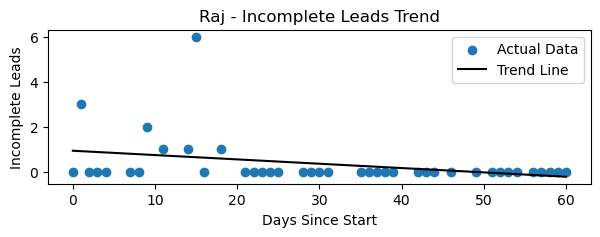

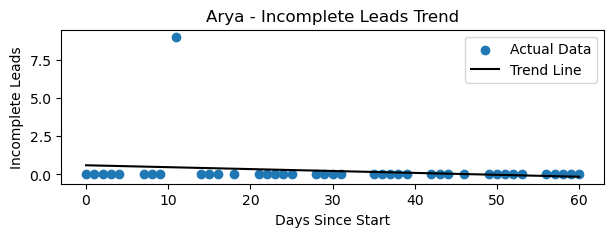

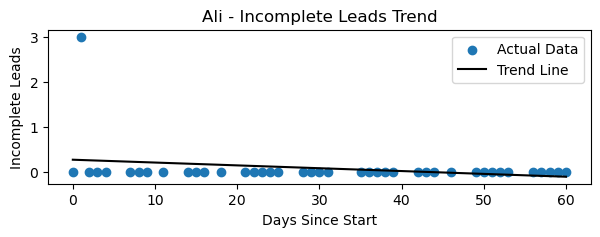

In [11]:
#QUESTION 5: INCOMPLETE LEADS TREND USING REGRESSION LINE
import pandas as pd #pandas for filtering and analysis
import matplotlib.pyplot as plt #matplot for visualisation of data
import numpy as np #numpy for calculating regression

df['date'] = pd.to_datetime(df['date'])
#converting 'date' col to proper datetime

df['days'] = (df['date'] - df['date'].min()).dt.days

"""
cannot plot a regression using raw dates, so we calculate days since start
for the x-axis
"""
names = df['associate_name'].unique()
"""
Failsafe - We could check if there's at least 2 data points per associate, 
(if len(x)< 2, print("insufficient data"),
but we assume that's already true for this dataset.
"""
for n in names:
    associate = df[df['associate_name'] == n] 
    #filtering data for the each associate
    x = associate['days'] #x-axis = days since start                
    y = associate['incomplete_leads'] #y-axis = incomplete leads

    slope, intercept = np.polyfit(x, y, 1)  
#np.polyfit fits a curve to our data points
#degree of '1' shows we are fitting a linear regression line (y = mx + c)
#'slope' (m) tells us the direction and steepness of the trend
#Positive slope = upward trend, a bad sign for incomplete leads
#Negative slope = downward trend, a good sign for incomplete leads
#'intercept' (c) is the starting point where the line crosses the y-axis

    trend = slope * x + intercept  
#equation of the line (y = mx + c) to calculate the trend line values
#these values help us draw a smooth line that represents the overall direction 
    plt.figure(figsize=(7, 2)) #chart dimensions - 7x2 in this case
    plt.scatter(x, y, label = 'Actual Data') #plotting of the data points
    plt.plot(x, trend, color = 'black', label = 'Trend Line') #drawing the line
    plt.title(f'{n} - Incomplete Leads Trend') #title of chart (n)
    plt.xlabel('Days Since Start') #x-axis label name
    plt.ylabel('Incomplete Leads') #y-axis label name
    plt.legend() #legend of the chart (in this case, 'actual' and 'trend')
    plt.show() #displays the chart (not required for jupyter specifically)

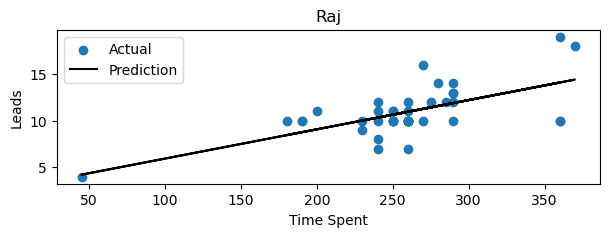

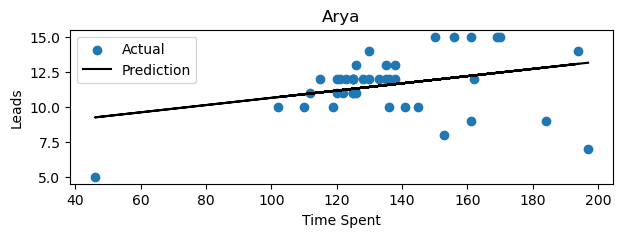

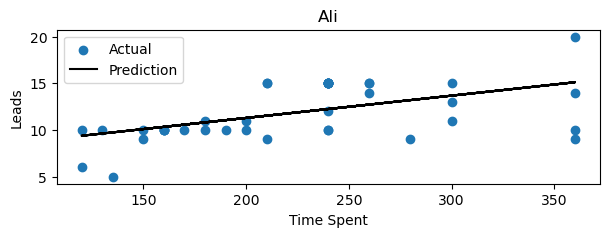

In [12]:
#QUESTION 10 PREDICTIVE ANALYSIS: USED LINEAR REGRESSION TO CALCULATE FUTURE TREND OF LEAD GENERATION
import pandas as pd #pandas library for handling and filtering the dataset
import numpy as np #numpy library for regression
import matplotlib.pyplot as plt #matplot library for graph

for n in df['associate_name'].unique(): #retains distinct names
    #looping through each associate, so we can apply regression for each associate individually
    temp_df = df[df['associate_name'] == n] 
    #created a temporary dataframe that contains only the rows for 'n' (current) associate
    x = temp_df['time_spent_lead_generating'] #x-axis: time spent in lead generation (in minutes)
    y = temp_df['leads'] # y-axis: number of leads generated
    #"how is time acting out for lead generation?"
    slope, intercept = np.polyfit(x, y, 1)
    #(np.polyfit) fits a polynomial (x,y are the variables we named, and degree 1 means a linear sequence
    y_predictions = slope * x + intercept #(y = mx + c)
    #y_predictions (y) = the predicted leads with respect to minutes spent
    #slope = rate of change in leads per minute
    #intercept = the place of the line crossing the y-axis
    """
    Could also import 'sklearn' or 'scikit-learn' package to check for Co-efficient of Determination(R²) 
    excluded R² here to focus on visual interpretation.
    this keeps it clearer for stakeholders who prefer charts over metrics.
    """
    plt.figure(figsize=(7, 2)) #figure dimensions. 7x2 in this case
    plt.scatter(x, y, label='Actual') #scatter plot label being 'actual'
    plt.plot(x, y_predictions, color='black', label='Prediction') #trend line depicting predicted leads
    plt.title(n) #title of the graph, depends on associate being viewed
    plt.xlabel("Time Spent") #x-axis label
    plt.ylabel("Leads") #y-axis label
    plt.legend() #legend of the graph (in this case, 'actual' and 'prediction'
    plt.show() #shows the graph (not required for jupyter specifically)
